In [1]:
import json
from langchain_openai import ChatOpenAI
import getpass
import os
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv())

def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")

_set_if_undefined("LANGCHAIN_API_KEY")

# Optional, add tracing in LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "false"
os.environ["LANGCHAIN_PROJECT"] = "critic no tools"


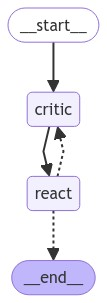

In [18]:
from langgraph.graph import END, StateGraph, START
from typing import Annotated
from typing_extensions import TypedDict
from operator import add
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage, SystemMessage, merge_message_runs

MAX_ITERATIONS = 4

dataset_name = "tabmwp"
class State(TypedDict):
    input: str
    prediction: str
    messages: Annotated[list, add]
    predictions: Annotated[list[str], add]
    iteration: int

critic_prompt = HumanMessage(content=("Inspect the previous messages and identify any potential issues or errors. "
                                      "Reflect on the process of problem-solving. "
                                      "What's the problem of the previous answer? "
                                      "If there are tool calls, what are the issues with tool calls? (Tool selection, parameters, etc.)"
                                      "Is the final answer truthful?"
                                      "Your response should be as brief as possible . "))

if dataset_name in ["hotpot_qa", "trivia_qa", "ambig_qa"]:
    revise_prompt = HumanMessage(content=("Based on the previous criqique, revise your answer. Remember your FINAL ANSWER should be clear and concise.(a single number or phrases, not a sentence!) "
                                      "Your response should follow the original format. For following example:\n\n"
                                      "Proposed Answer: Let's think step by step. ...\n"
                                      "FINAL ANSWER: <FINAL ANSWER>\n"))
    llm = ChatOpenAI(temperature=0, top_p=1,base_url="https://api.chsdw.top/v1", model="gpt-4o-mini")
elif dataset_name in ["gsm8k", "svamp", "tabmwp"]:
    revise_prompt = HumanMessage(content=("Based on the previous criqique, revise your answer.  "
                                      "Your response should follow the original format:\n"
                                      "# Python code, return answer\n ... "))
    llm = ChatOpenAI(temperature=0.5, top_p=1, base_url="https://api.chsdw.top/v1", model="gpt-4o-mini")
    
async def criticize(state):
    try:
        messages = [critic_prompt]
        critique = await llm.ainvoke(state["messages"] + messages)
    except:
        return {
        "iteration":state["iteration"] + 1 
        } 
    return {
    "messages": [HumanMessage(content=critique.content)],
    "iteration":state["iteration"] + 1 
    }

async def react(state):
    try:
        question_message = HumanMessage(content=state["input"])
        messages = [revise_prompt, question_message]
        result = await llm.ainvoke(state["messages"] + messages)
        result_message = AIMessage(**result.dict(exclude={"type", "name"}))
    except:
        return{
            "messages": [SystemMessage(content="Sorry, I have trouble understanding your answer. Please try again.")],
            "predictions": [],
        }
    return {
        "messages": [revise_prompt, HumanMessage(content=state["input"]), result_message],
        "predictions": [result_message.content],
    }

# Either agent can decide to end
from typing import Literal

def should_end(state) -> Literal["critic", "__end__"]:
    if state["iteration"] == 4:
        return "__end__"
    else:
        return "critic"
    

builder = StateGraph(State)

builder.add_node("critic", criticize)
builder.add_node("react", react)

builder.add_edge(START, "critic")
builder.add_edge("critic", "react")
builder.add_conditional_edges("react", should_end)

graph = builder.compile()
    

async def reflect(item, graph, dataset_name:str="hotpot_qa") -> str:
    if dataset_name in ["hotpot_qa", "trivia_qa", "ambig_qa"]:
        input={"messages": [HumanMessage(content=f"{item["question"]}\n{item["prediction"]}")],
               "input": item["question"],
               "prediction": item["prediction"],
               "iteration": 0}
    elif dataset_name in ["gsm8k", "svamp"]:
        input={"messages": [HumanMessage(content=f"Use python code solve the following problem, variable <answer> should contain the final answer. Use \"print(answer)\" to get the final answer.\n\n{item["question"]}\n{item["prediction"]}")],
               "iteration": 0,
               "input": item["question"],
               "prediction": item["prediction"],}
    elif dataset_name in ["tabmwp"]:
        input = {
            "messages": [HumanMessage(content=f"Use python code solve the following problem, variable <answer> should contain the final answer. Use \"print(answer)\" to get the final answer.\n\nRead the following table regarding {item["table_title"]} and then write Python code to answer a question:\n\n{item["table"]}\n{item["question"]}\n\n{item["prediction"]}")],
            "iteration": 0,
            "input": f"Read the following table regarding {item['table_title']} and then write Python code to answer a question:\n\n{item['table']}\n\n{item['question']}",
            "prediction": item["prediction"],
        }      
    try:
        result = await graph.ainvoke(input=input)
        return result
    except Exception as e:
        return str(e)
    


from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


# hotpot_qa gsm8k svamp trivia_qa

In [16]:
dataset_name = "tabmwp"
mode = "critic_no_tool"
num_test_sample = 1000
temperature = 0.5
top_p = 1
batch_size = 100
results = []

from datasets import load_dataset
dataset = load_dataset("json", data_files=f"../output/inference/{dataset_name}/pot_1000_temperature_0_top-p_1.jsonl", split="train")
if dataset_name == "svamp":
    dataset = dataset.map(lambda x: {"question": f"{x["Body"]} {x["Question"]}", "answer": x["Answer"]})
if num_test_sample > 0:
    dataset = dataset.select(range(num_test_sample))
print(dataset, {dataset[0][k] for k in ["question", "answer", "prediction"]})
print(llm.temperature, llm.top_p)

Dataset({
    features: ['question', 'choices', 'answer', 'unit', 'table_title', 'table', 'table_for_pd', 'row_num', 'column_num', 'solution', 'ques_type', 'ans_type', 'grade', 'split', 'idx', 'prediction'],
    num_rows: 1000
}) {'Some friends discussed the sizes of their coin collections. What is the mean of the numbers?', '84', '# Python Code, return answer\nnumber_of_coins = [76, 94, 86, 84, 80, 83, 82, 87]\nmean_number_of_coins = sum(number_of_coins) / len(number_of_coins)\nanswer = mean_number_of_coins\nprint(answer)'}
0.5 1.0


In [27]:
from tqdm.asyncio import tqdm_asyncio
for i in range(300, 1000, batch_size):
    results.extend(await tqdm_asyncio.gather(*(reflect(item, graph, dataset_name) for item in dataset.select(range(i, min(i+batch_size, len(dataset)))))))
    with open (f"/Users/ariete/Projects/self-improve/output/v2/{dataset_name}/{mode}_{len(dataset)}_temperature_{temperature}_top-p_{top_p}.jsonl", "w") as f:
        for idx, result in enumerate(results):
            f.write(json.dumps({"idx": idx, "question": dataset[idx]["question"], "answer":dataset[idx]["answer"], "predictions": results[idx]["predictions"]}) + "\n")

100%|██████████| 100/100 [01:44<00:00,  1.04s/it]
